<a href="https://colab.research.google.com/github/Riwaj22/TensorFlow/blob/main/People_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Ipython

In [2]:
from IPython.display import Image, display


In [3]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.layers import Conv2D, BatchNormalization, Reshape, Conv2DTranspose, Dropout, MaxPooling2D, LayerNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Rescaling, Normalization
from tensorflow.keras.initializers import RandomNormal
from IPython.display import Image, display  # Corrected import
import PIL
from PIL import ImageOps
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import Model, Sequential
import scipy.io


In [4]:
!pip install kaggle


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"riwaj111111","key":"723ca689a952d10beb6c2be1de3e574d"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d tthien/shanghaitech


Dataset URL: https://www.kaggle.com/datasets/tthien/shanghaitech
License(s): unknown
shanghaitech.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip shanghaitech.zip


Archive:  shanghaitech.zip
replace ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Data Preperation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
in_x, in_y = 768, 1024
out_x, out_y = 96, 128
sub_sampling_factor = in_x // out_x

In [3]:
def gauss_distribution(x, u = 0, sigma = 10):
    return np.expand_dims(((1/(np.sqrt(2*np.pi*(sigma**2))))*np.exp((-0.5)*((x-u)/sigma)**2)), axis = 0)

In [4]:
def get_density_map_gaussian(im, points, sigma = 10,):
    gaussian_radius = sigma

    density_map = np.zeros((out_x, out_y))

    h, w = out_x, out_y

    num_gt = len(points)

    for point in points:
        point = np.round(point).astype(int)
        point[0], point[1] = min(h-1, point[1]), min(w-1, point[0])

        # (-range, range, num_points), gives a list of points = num_points in the given range
        x = np.linspace(-gaussian_radius, gaussian_radius, (gaussian_radius*2) + 1)

        gaussian_map = np.multiply(gauss_distribution(x), gauss_distribution(x).T)
        gaussian_map /= np.sum(gaussian_map)

        xmin, xmax, ymin, ymax = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]

        if point[1] < gaussian_radius:
            xmin = gaussian_radius - point[1]
        if point[0] < gaussian_radius:
            ymin = gaussian_radius - point[0]
        if point[1] + gaussian_radius >= w:
            xmax = gaussian_map.shape[1] - (gaussian_radius + point[1] - w) - 1
        if point[0] + gaussian_radius >= h:
            ymax = gaussian_map.shape[0] - (gaussian_radius + point[0] - h) - 1

        density_map[
            max(0, point[0]-gaussian_radius):min(density_map.shape[0], point[0] + gaussian_radius + 1),
            max(0, point[1]-gaussian_radius):min(density_map.shape[1], point[1] + gaussian_radius + 1)
        ] += gaussian_map[ymin:ymax, xmin:xmax]

    density_map /= np.sum(density_map / len(points)) #mean normalization
    return density_map

In [5]:
import scipy.io
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [14]:
train_images


NameError: name 'train_images' is not defined

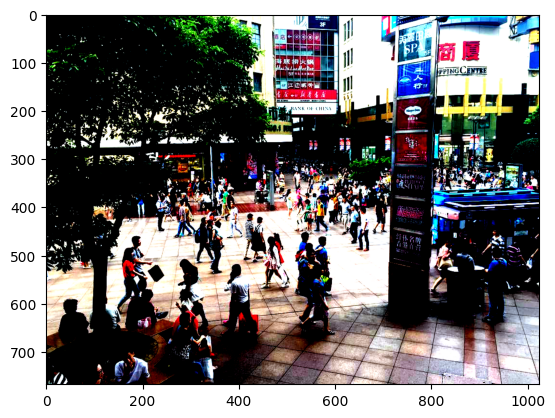

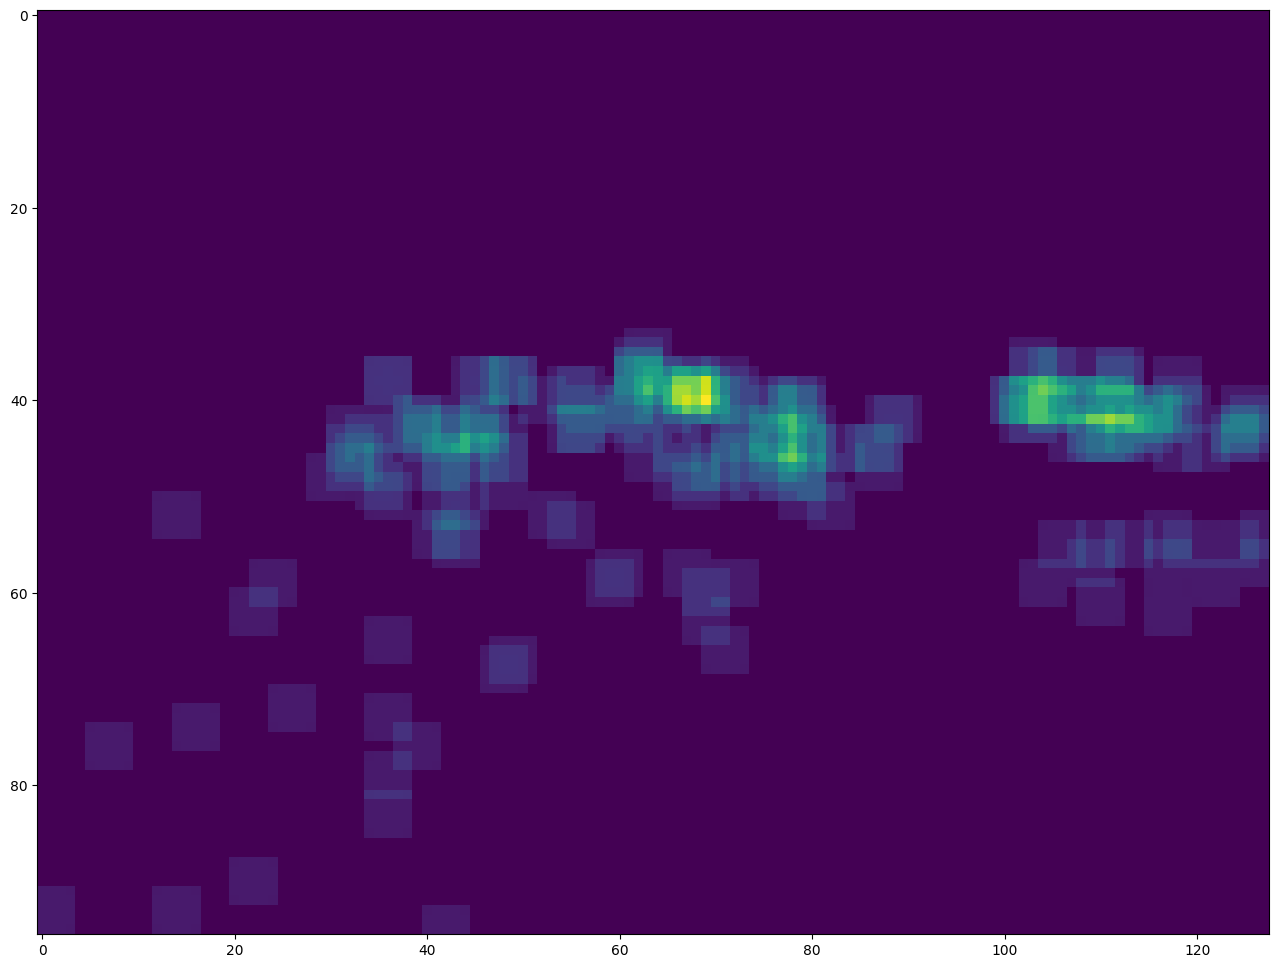

In [6]:
train_images = "/content/ShanghaiTech/part_B/train_data/images/"
train_maps = "/content/ShanghaiTech/part_B/train_data/ground-truth/"

IN = 'IMG_100'
im_array = img_to_array(load_img(train_images + IN + '.jpg', target_size = (in_x, in_y)))

im_array /= 255
im_array[:,:,0] = (im_array[:,:,0] - np.mean(im_array[:,:,0])) / np.std(im_array[:,:,0])
im_array[:,:,1] = (im_array[:,:,1] - np.mean(im_array[:,:,1])) / np.std(im_array[:,:,1])
im_array[:,:,2] = (im_array[:,:,2] - np.mean(im_array[:,:,2])) / np.std(im_array[:,:,2])

X = im_array
plt.imshow(X)

mat = scipy.io.loadmat(train_maps + 'GT_' + IN + '.mat') # gives a dict
points = mat['image_info'][0][0][0][0][0]

points /= sub_sampling_factor

y = get_density_map_gaussian(im_array, points, sigma = 2,)

plt.figure(figsize = (20, 12))
plt.imshow(y)
plt.show()

In [7]:
import os
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, maps, batch_size, sub_sampling_factor,):
        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_images_list = os.listdir(images)
        self.sub_sampling_factor = sub_sampling_factor

    def __len__(self):
        return int(np.floor(len(self.train_images_list)/self.batch_size))

    def _data_generation(self, idx):
        X = []
        y = []

        for j in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            im_array = img_to_array(load_img(self.images + os.listdir(self.images)[j], target_size = (in_x, in_y)))

            im_array /= 255
            im_array[:,:,0] = (im_array[:,:,0] - np.mean(im_array[:,:,0])) / np.std(im_array[:,:,0])
            im_array[:,:,1] = (im_array[:,:,1] - np.mean(im_array[:,:,1])) / np.std(im_array[:,:,1])
            im_array[:,:,2] = (im_array[:,:,2] - np.mean(im_array[:,:,2])) / np.std(im_array[:,:,2])

            X.append(im_array)

            mat = scipy.io.loadmat(self.maps+os.listdir(self.maps)[j]) # gives a dict
            points = mat['image_info'][0][0][0][0][0]

            points /= sub_sampling_factor

            y.append(get_density_map_gaussian(im_array, points, sigma = 2,))

        return tf.convert_to_tensor(X), tf.convert_to_tensor(y)
    def __getitem__(self, idx):
        a, b = self._data_generation(idx)
        return a, b

In [8]:
BATCH_SIZE = 1
LR = 1e-4
EPOCH = 1000

In [9]:
test_images = "/content/ShanghaiTech/part_B/test_data/images/"
test_maps =  "/content/ShanghaiTech/part_B/test_data/ground-truth/"

In [10]:
train_gn = DataGenerator(train_images, train_maps, BATCH_SIZE, sub_sampling_factor)
test_gn = DataGenerator(test_images, test_maps, BATCH_SIZE, sub_sampling_factor)

In [11]:
base_model_raw = tf.keras.applications.VGG16(
    weights = 'imagenet',
    input_shape = (in_x, in_y, 3),
    include_top = False
)

block4_conv3 = [base_model_raw.get_layer(layer_name).output for layer_name in ['block4_conv3']]

base_model = tf.keras.models.Model(inputs = [base_model_raw.inputs], outputs = block4_conv3)
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 768, 1024, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 768, 1024, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 768, 1024, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 384, 512, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 384, 512, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 384, 512, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 192, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 192, 256, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 192, 256, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 192, 256, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 96, 128, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 96, 128, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 96, 128, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 96, 128, 512)        │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 7,635,264 (29.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.layers import Conv2D, Reshape, Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D
from tensorflow.keras.models import Model

def build_model(in_x, in_y):
    inputs = Input(shape=(in_x, in_y, 3))

    # Example base model (VGG16, you can adjust accordingly)
    base_model = tf.keras.applications.VGG16(input_shape=(in_x, in_y, 3), include_top=False)
    x = base_model(inputs)

    # Add layers to modify output shape
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)  # Upsample
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)  # Upsample again

    # Final layer to match the target shape
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Resize the output to ensure it matches (96, 128)
    out = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=(96, 128)))(x)

    model = Model(inputs=inputs, outputs=out)
    return model

# Example dimensions
in_x, in_y = 384, 512
model = build_model(in_x, in_y)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 384, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 12, 16, 512)         │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 12, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 24, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 48, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 64, 1)           │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 96, 128, 1)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,549,569 (70.76 MB)

 Trainable params: 18,549,569 (70.76 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [14]:
def custom_loss(y_true, y_pred):

    # Resize if necessary
    if y_pred.shape[1:] != y_true.shape[1:]:
        y_pred = tf.image.resize(y_pred, size=(y_true.shape[1], y_true.shape[2]))
    return tf.reduce_mean(tf.square(y_true - y_pred))


In [15]:
from tensorflow.keras.optimizers import Adam


LR = 1e-5
model.compile(
    loss = custom_loss,
    optimizer = Adam(learning_rate = LR),
    metrics = ['accuracy']


)

checkpoint_path = 'people_counting.weights.h5'

In [16]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    monitor = 'loss',
    mode = 'min',
    save_best_only = True
)

train_history = model.fit(train_gn, validation_data = test_gn, epochs = 7, verbose = 1, shuffle = True,
                          callbacks = [callback])

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 252s 590ms/step - accuracy: 0.8702 - loss: 0.0057 - val_accuracy: 0.8656 - val_loss: 0.0016
Epoch 2/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 278s 688ms/step - accuracy: 0.8671 - loss: 0.0018 - val_accuracy: 0.8656 - val_loss: 0.0016
Epoch 3/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 276s 575ms/step - accuracy: 0.8705 - loss: 0.0017 - val_accuracy: 0.8656 - val_loss: 0.0014
Epoch 4/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 261s 572ms/step - accuracy: 0.8715 - loss: 0.0015 - val_accuracy: 0.8656 - val_loss: 0.0013
Epoch 5/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 262s 572ms/step - accuracy: 0.8698 - loss: 0.0014 - val_accuracy: 0.8656 - val_loss: 0.0013
Epoch 6/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 229s 569ms/step - accuracy: 0.8745 - loss: 0.0012 - val_accuracy: 0.8656 - val_loss: 0.0014
Epoch 7/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 260s 565ms/step - accuracy: 0.8711 - loss: 0.0014 - val_accuracy: 0.8656 - val_loss: 0.0013


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The actual number of people is= 27
The predicted number of people is = 66.28517


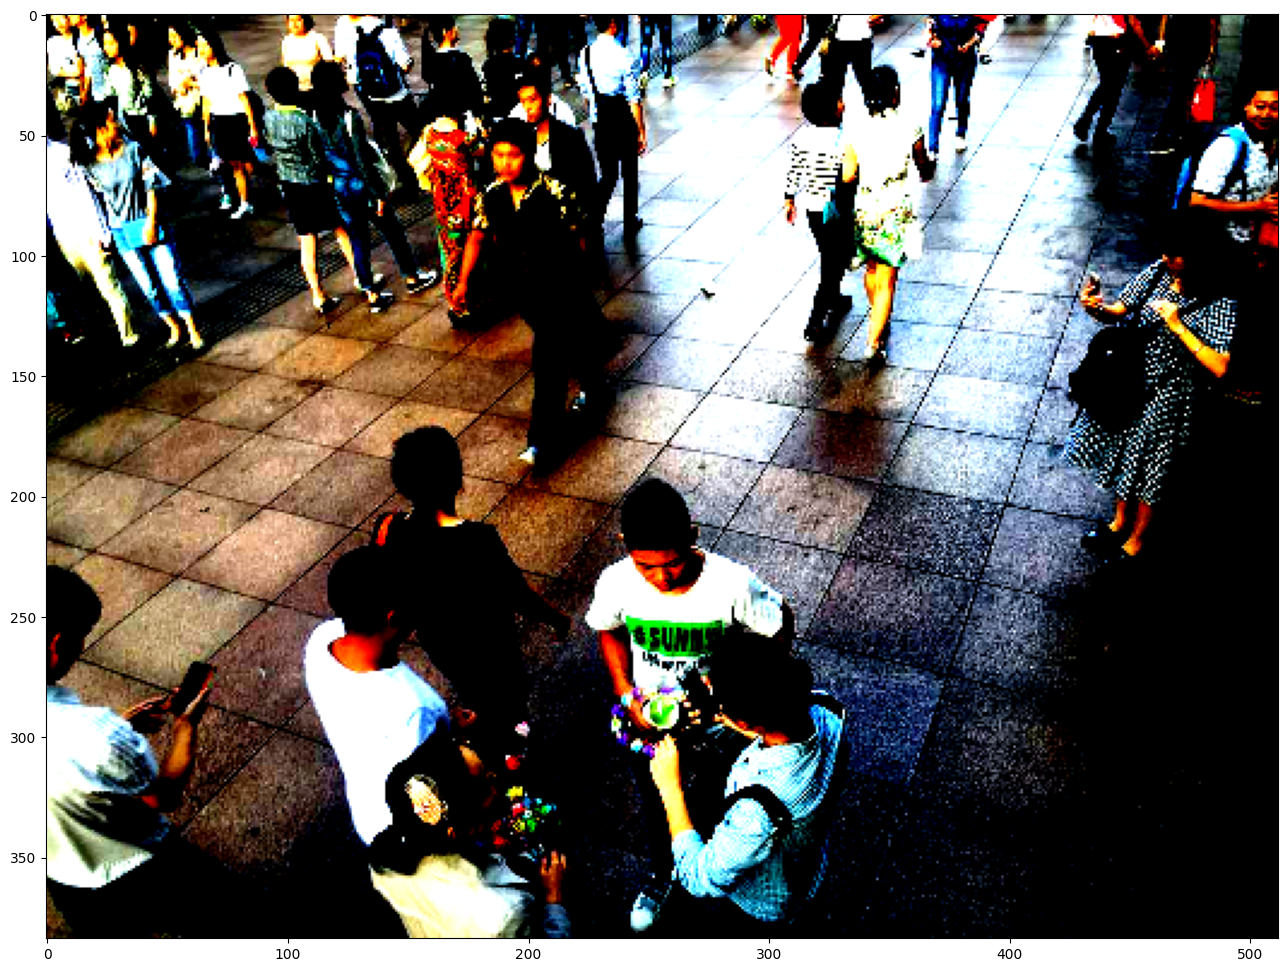

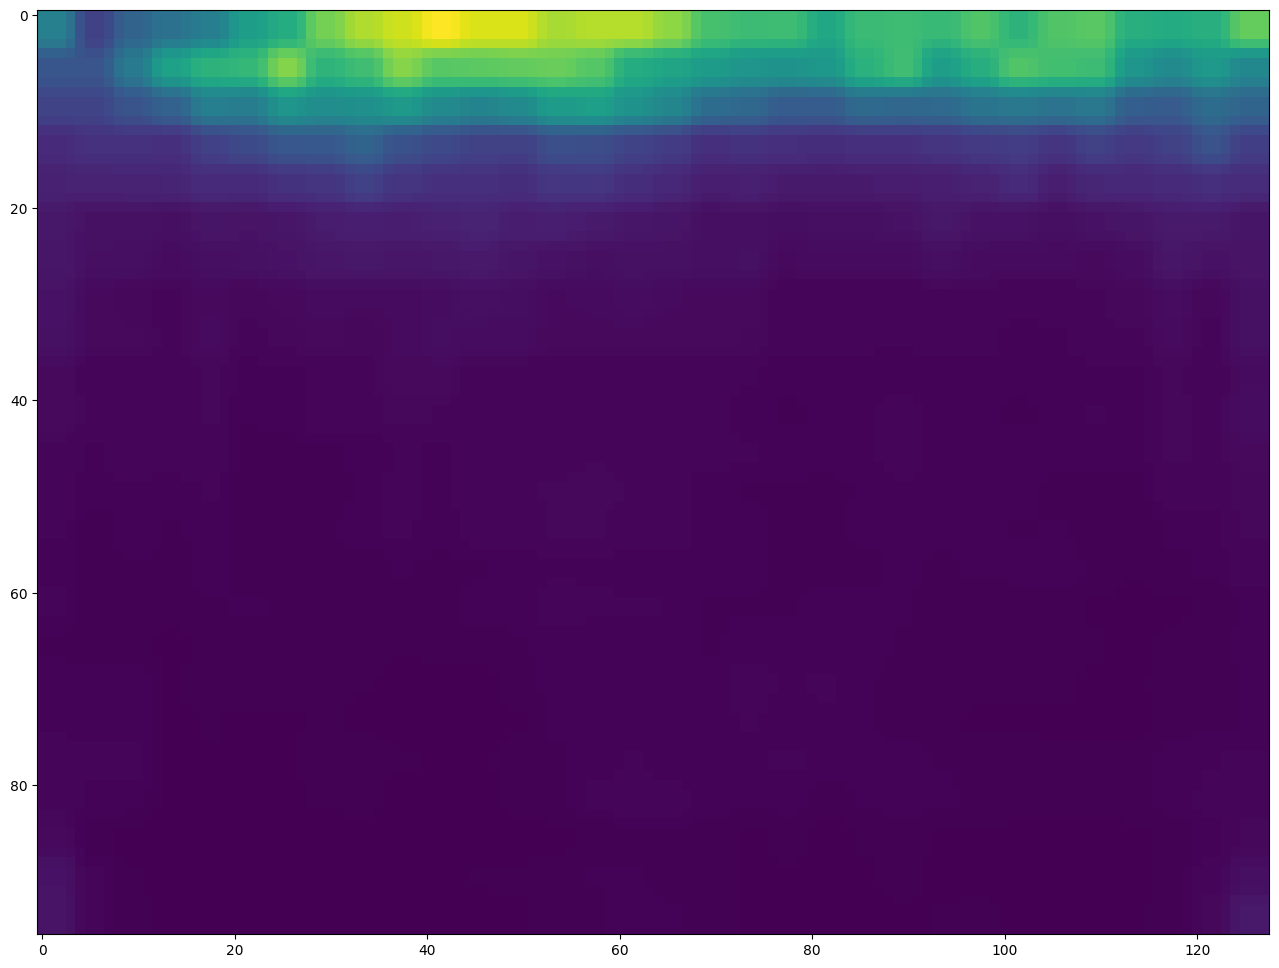

In [19]:
IN ='IMG_102'

im_array=img_to_array(load_img(train_images + IN + '.jpg',target_size=(in_x, in_y)))
im_array/=255.
im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])

plt.figure(figsize=(20,12))
plt.imshow(im_array)

output=model.predict(tf.expand_dims(im_array,axis=0))
output=np.reshape(output,(out_x,out_y))

n_people=np.sum(output)
mat=scipy.io.loadmat(train_maps+'GT_'+IN+'.mat')
points=mat['image_info'][0][0][0][0][0]
points/=sub_sampling_factor

num_gt=np.squeeze(points).shape[0]
print("The actual number of people is=",num_gt)
print("The predicted number of people is =",n_people)

plt.figure(figsize=(20,12))
plt.imshow(output)